# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model. 
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [58]:
%pip install hf_xet
%pip install yfinance

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import math
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [2]:
df_news = pd.read_csv('../df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [3]:
df_meta = pd.read_csv('../df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [ ]:
model = CrossEncoder('cross-encoder/nli-deberta-v3-base')
hypotheses = [
    "This headline has a positive sentiment.",
    "This headline has a negative sentiment."
]

def get_sentiment_scores(headline):
    pairs = [(headline, hyp) for hyp in hypotheses]
    scores = model.predict(pairs)
    # model outputs [contradiction, neutral, entailment]
    return [score[2] for score in scores]

In [23]:
positive_probs = []
negative_probs = []
sentiments = []

for idx in range(len(df_news)):
    headline = df_news["SUMMARY"].iloc[idx]
    sentiment_scores = get_sentiment_scores(headline)
    positive_probs.append(sentiment_scores[0])
    negative_probs.append(sentiment_scores[1])
    sentiments.append(sentiment_scores[0] - sentiment_scores[1])

df_news["POSITIVE_PROB"] = positive_probs
df_news["NEGATIVE_PROB"] = negative_probs
df_news["SENTIMENT"] = sentiments

In [24]:
df_news.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,4.973114,5.141531,-0.168417
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,4.873335,5.122154,-0.248819
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.154522,0.940822,-0.786300
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,5.338489,4.898020,0.440468
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,4.675629,4.433777,0.241852


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [ ]:
df_news_grouped = df_news.groupby("PUBLICATION_DATE").agg(list)
df_news_grouped["AVG_POSITIVE_PROB"] = df_news_grouped["POSITIVE_PROB"].apply(np.mean)
df_news_grouped["AVG_NEGATIVE_PROB"] = df_news_grouped["NEGATIVE_PROB"].apply(np.mean)
df_news_grouped["AVG_SENTIMENT"] = df_news_grouped["SENTIMENT"].apply(np.mean)
df_news_grouped.head()

,TICKER,TITLE,SUMMARY,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT,AVG_POSITIVE_PROB,AVG_NEGATIVE_PROB,AVG_SENTIMENT
PUBLICATION_DATE,,,,,,,,,,,
2024-07-12 13:22:00+00:00,[DOC],[Is It Wise to Hold Healthpeak Properties (DOC...,[High demand for lab assets and rising senior ...,[Zacks],[https://finance.yahoo.com/news/wise-hold-heal...,[2.4937493801116943],[1.056098222732544],[1.4376511573791504],2.493749,1.056098,1.437651
2024-07-22 18:00:48+00:00,[DOC],[How To Earn $500 Per Month From Healthpeak Pr...,[We all have to visit doctors' offices from ti...,[Benzinga],[https://finance.yahoo.com/news/earn-500-per-m...,[4.237163543701172],[4.65846061706543],[-0.4212970733642578],4.237164,4.658461,-0.421297
2024-08-19 16:00:12+00:00,[DOC],[Healthpeak (DOC) Upgraded to Buy: Here's What...,[Healthpeak (DOC) might move higher on growing...,[Zacks],[https://finance.yahoo.com/news/healthpeak-doc...,[-1.0734097957611084],[-2.6252028942108154],[1.551793098449707],-1.073410,-2.625203,1.551793
2024-09-13 16:15:27+00:00,[DOC],[How the 10-year yield affects REITs],[Interest rate-sensitive REITs (Real Estate In...,[Yahoo Finance Video],[https://finance.yahoo.com/video/10-yield-affe...,[3.4485011100769043],[-0.6667801737785339],[4.115281105041504],3.448501,-0.666780,4.115281
2024-10-26 07:07:48+00:00,[DOC],[Healthpeak Properties Inc (DOC) Q3 2024 Earni...,[Healthpeak Properties Inc (DOC) reports robus...,[GuruFocus.com],[https://finance.yahoo.com/news/healthpeak-pro...,[0.12329191714525223],[-1.020884394645691],[1.1441763639450073],0.123292,-1.020884,1.144176


In [33]:
df_news_grouped.shape

(3748, 11)

In [135]:
df_news["PUBLICATION_DATE"] = pd.to_datetime(df_news["PUBLICATION_DATE"])
start_date = df_news["PUBLICATION_DATE"].min().strftime("%Y-%m-%d")
end_date = df_news["PUBLICATION_DATE"].max().strftime("%Y-%m-%d")
ticker_list = df_news["TICKER"].unique().tolist()

prices = yf.download(ticker_list, start=start_date, end=end_date)

C:\Users\hille\AppData\Local\Temp\ipykernel_2276\3109969491.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker_list, start=start_date, end=end_date)
[*********************100%***********************]  487 of 487 completed


In [ ]:
daily_returns = prices["Close"].pct_change().dropna()
# test
print(daily_returns.head())

Date
2024-07-15    0.016743
2024-07-16    0.001792
2024-07-17   -0.025296
2024-07-18   -0.020535
2024-07-19    0.000580
Name: AAPL, dtype: float64
Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2024-07-15 -0.009226  0.016743 -0.004149  0.002998 -0.006849  0.006839   
2024-07-16  0.038547  0.001792  0.006963  0.027442 -0.002331 -0.000515   
2024-07-17 -0.018815 -0.025296  0.035875 -0.021552  0.019081  0.007826   
2024-07-18 -0.011461 -0.020535 -0.023564 -0.007568 -0.044039  0.003780   
2024-07-19 -0.001440  0.000580  0.006895  0.007557  0.019586 -0.021783   

Ticker           ACN      ADBE       ADI       ADM  ...       WST       WTW  \
Date                                                ...                       
2024-07-15  0.023307  0.011913 -0.003521 -0.013690  ... -0.008886 -0.003331   
2024-07-16  0.022431  0.001467  0.023599  0.018296  ...  0.028115  0.003760   
2024-07-17  0.0018

In [158]:
# Function to get the daily returns of a specific ticker in a given day
def get_daily_returns(ticker, date):
    # If date is a Timestamp, convert to string in the same format as the index
    if isinstance(date, pd.Timestamp):
        date = date.strftime("%Y-%m-%d")
    try:
        return daily_returns.at[date, ticker]
    except (KeyError, ValueError):
        return np.nan

In [159]:
# Test function
print(get_daily_returns("AAPL", "2024-07-12"))

nan


In [164]:
for date in df_news_grouped.index:
    daily_prices = []
    ticker_list = df_news_grouped.loc[date, "TICKER"]
    for ticker in ticker_list:
        date_str = date.strftime("%Y-%m-%d")
        price = get_daily_returns(ticker, date_str)
        daily_prices.append(price)
    # Filter out NaN values before calculating mean
    valid_prices = [p for p in daily_prices if not pd.isna(p)]
    if valid_prices:
        df_news_grouped.at[date, 'AVG_RETURN'] = np.mean(valid_prices)
    else:
        df_news_grouped.at[date, 'AVG_RETURN'] = np.nan


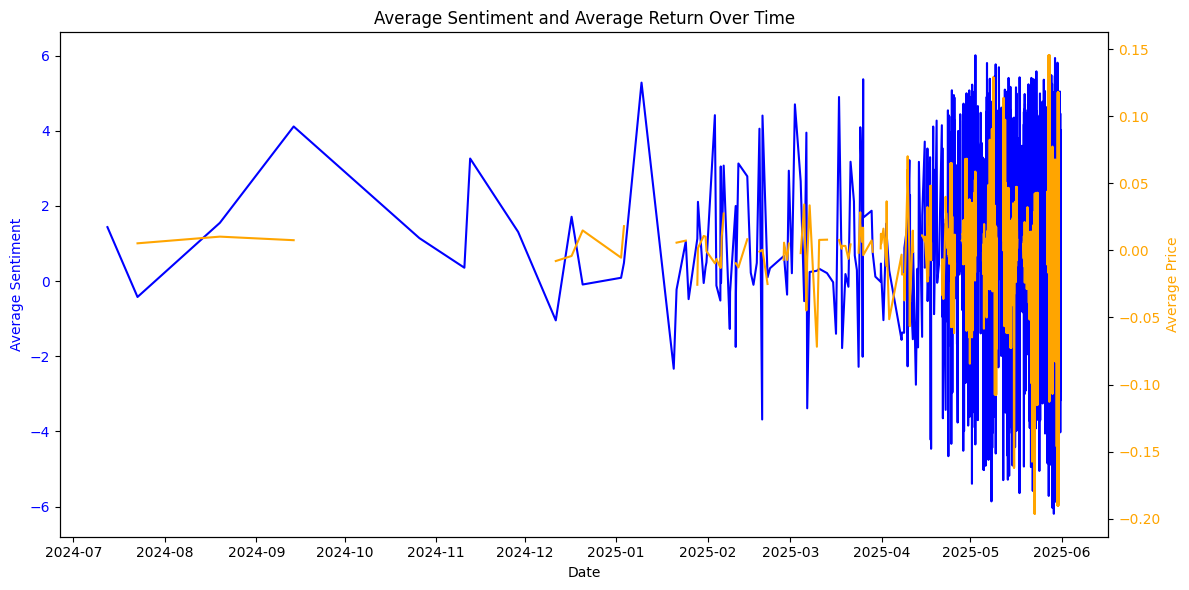

In [165]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Sentiment", color="blue")
ax1.plot(df_news_grouped.index, df_news_grouped["AVG_SENTIMENT"], label="Average Sentiment", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Secondary y-axis for average price
ax2 = ax1.twinx()
ax2.set_ylabel("Average Price", color="orange")
ax2.plot(df_news_grouped.index, df_news_grouped["AVG_RETURN"], label="Average Return", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

plt.title("Average Sentiment and Average Return Over Time")
fig.tight_layout()
plt.show()


## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [ ]:
# Create a data frame to hold the portfolio value over time
df_portfolio = pd.DataFrame(index=df_news_grouped.index)
# calculate the average of all daily returns per day

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [ ]:
# CODE HERE
# Use as many coding cells as you need

['Industrials' 'Healthcare' 'Technology' 'Utilities' 'Financial Services'
 'Basic Materials' 'Consumer Cyclical' 'Real Estate'
 'Communication Services' 'Consumer Defensive' 'Energy']


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


YOUR WRITTEN RESPONSE HERE




### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


YOUR WRITTEN RESPONSE HERE

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

YOUR WRITTEN RESPONSE HERE


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

YOUR WRITTEN RESPONSE HERE
